In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (10,6)

## Week 8: OpenStreetMap and Urban Networks
March 27, 2019

## The roadmap

- Last week Big data: dask and datashader
- Today + next week: "geo data science in the wild"
    - Profiling useful tools for real-life applications
    - A little bit more "lab" based
- Several weeks of web-based data visualization

## Housekeeping

- HW #5 is due in 1 1/2 weeks (April 5)
    - Covers web scraping and big data
- Look for graded homeworks to be uploaded in the next few days
- We'll review final project guidelines next week, written proposal due in about a month 

## Today: OpenStreetMap (OSM)

- Two tools that make working with OSM data very easy
- What kind of questions can we answer?
    - Street orientations 
    - Mapping event points to streets: car crashes
    - Mapping amenities
    - Network-constrained distances: accessibility

## OSM: what is it?

- Collaborative mapping
- A free editable map of the World
- Sort of like Wikipedia for maps

**Great source of data: street networks and a wealth of amenity information**

https://www.openstreetmap.org

## Working with OSM data

- Raw data is very messy
- Two relatively new, amazing Python packages greatly simply the process
- Related, but complementary features    
    - **OSMnx:** downloading and manipulating streets as networks
    - **Pandana:** networks focused on accessibility of amenities

## Part 1: OSMnx

Several key features: 

- Downloading political boundaries for cities, states, countries, etc
- Downloading street networks
- Analyzing networks: routing, visualization, statistics

  - [GitHub](https://github.com/gboeing/osmnx)
  - [Introductory Blog Post](https://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [Jupyter Notebook Examples](https://github.com/gboeing/osmnx-examples/tree/master/notebooks)
  - [Documentation](https://osmnx.readthedocs.io)

In [3]:
import osmnx as ox

## Getting OSM shapefiles

Key function: `gdf_from_place()`

**Important: Be careful to pass the right place name that OSM needs**

In [4]:
philly = ox.gdf_from_place('Philadelphia, PA, USA')
philly.head()

bbox_east  bbox_north  bbox_south  bbox_west  \
0 -74.955831   40.137959   39.867005 -75.280298   

                                            geometry  \
0  POLYGON ((-75.28029770000001 39.9750019, -75.2...   

                                          place_name  
0  Philadelphia, Philadelphia County, Pennsylvani...

We can plot it just like any other GeoDataFrame

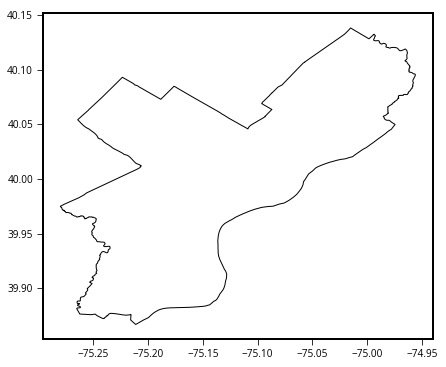

In [5]:
philly.plot(facecolor='none', edgecolor='black')

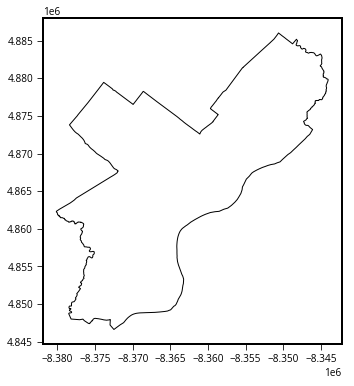

In [6]:
# or project it to Web Mercator first
philly.to_crs(epsg=3857).plot(facecolor='none', edgecolor='black') 

## Projecting and plotting with OSMnx

Key functions: 
- `project_gdf()`: automatically projects to Universal Transverse Mercator (UTM)
- `plot_shape()`

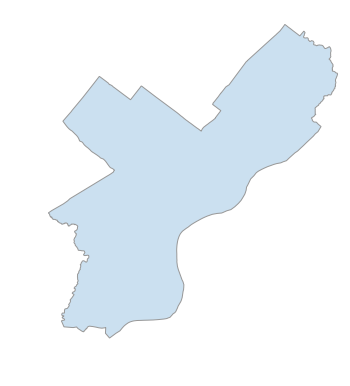

In [7]:
# an automatic, nice looking plot
ox.plot_shape(ox.project_gdf(philly));

We can get the boundary for anything identified as a "place" by OSM

In [8]:
# some examples
place1 = ox.gdf_from_place('Manhattan, New York City, New York, USA')
place2 = ox.gdf_from_place('Miami-Dade County, Florida')
place3 = ox.gdf_from_place('Florida, USA')
place4 = ox.gdf_from_place('Spain')

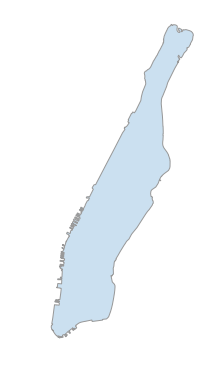

In [9]:
ox.plot_shape(ox.project_gdf(place1));

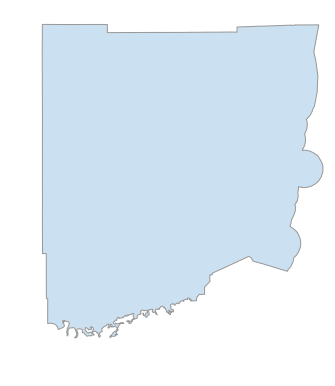

In [10]:
ox.plot_shape(ox.project_gdf(place2));

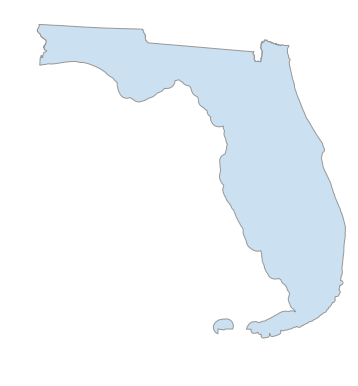

In [11]:
ox.plot_shape(ox.project_gdf(place3));

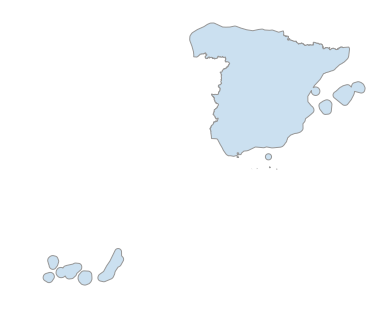

In [12]:
ox.plot_shape(ox.project_gdf(place4));

## Downloading street networks

Key functions: `graph_from_*` 

Can downloaded street networks using input:
  - bounding box (be careful of the lat/lng order)
  - address
  - place name
  - polygon
  - point

### Street network around an address

Get streets within 500 meters of the center of Northern Liberties

In [13]:
G = ox.graph_from_address("Northern Liberties, Philadelphia, PA", 
                          distance=500)

Project and plot it:

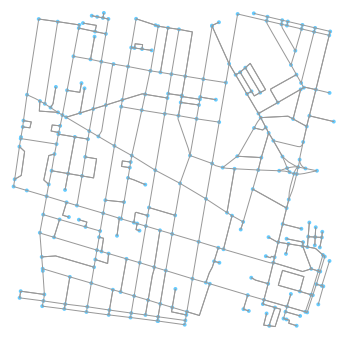

In [14]:
G_projected = ox.project_graph(G)
ox.plot_graph(G_projected);

Remove the blue nodes:

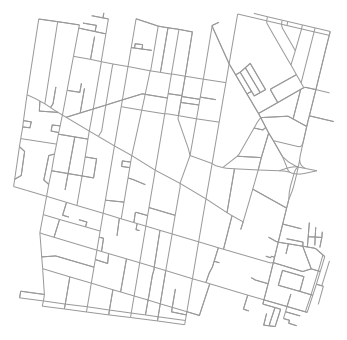

In [15]:
ox.plot_graph(G_projected, node_size=0);

Let's zoom out to 2,000 meters. This will take a little longer.

In [16]:
G = ox.graph_from_address("Northern Liberties, Philadelphia, PA", 
                          distance=2000)
G_projected = ox.project_graph(G)

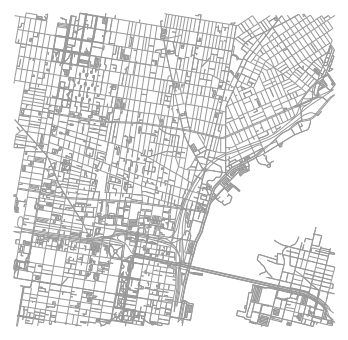

In [17]:
ox.plot_graph(G_projected, node_size=0);

### Getting different network types

- `drive` - get drivable public streets (but not service roads)
- `drive_service` - get drivable streets, including service roads
- `walk` - get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
- `bike` - get all streets and paths that cyclists can use
- `all` - download all non-private OSM streets and paths
- `all_private` - download all OSM streets and paths, including private-access ones (default)

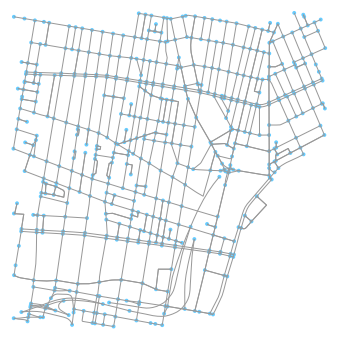

In [18]:
# the "drive" network
G = ox.graph_from_address("Northern Liberties, Philadelphia, PA", 
                          network_type='drive')
ox.plot_graph(G);

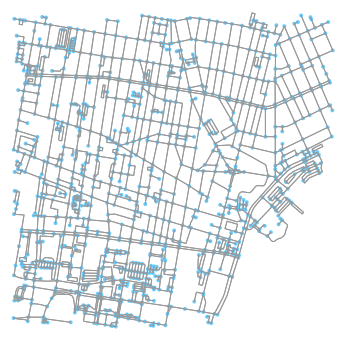

In [19]:
# the "walk" network
G = ox.graph_from_address("Northern Liberties, Philadelphia, PA", 
                           network_type='walk')
ox.plot_graph(ox.project_graph(G));

### Street network within a place boundary

Use `graph_from_place()` to get the streets within a specific OSM place.

**Note: the place query has to be resolved by OSM.**

In [20]:
berkeley = ox.graph_from_place("Berkeley, California", 
                               network_type='drive')

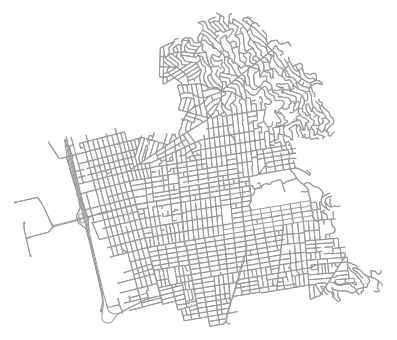

In [21]:
ox.plot_graph(ox.project_graph(berkeley), node_size=0);

### Streets within a specific polygon

**Example:** all streets within Northern Liberties and Fishtown

### First, Let's wrangle some Zillow boundaries

I downloaded Zillow neighborhood boundaries from https://www.zillow.com/howto/api/neighborhood-boundaries.htm

In [22]:
import geopandas as gpd

In [23]:
zillow = gpd.read_file("data/ZillowNeighborhoods-PA")

In [24]:
zillow.head()

State      County               City        Name RegionID  \
0    PA    Delaware          Wynnewood  Penn Wynne     6460   
1    PA  Montgomery          Wynnewood  Penn Wynne     6460   
2    PA     Chester  Easttown Township       Devon    11106   
3    PA        York      York Township        Spry    13975   
4    PA   Allegheny         Pittsburgh     Dormont    17799   

                                            geometry  
0  POLYGON ((-75.25734199999994 39.98964600000005...  
1  POLYGON ((-75.25734199999994 39.98964600000005...  
2  POLYGON ((-75.43213 40.064705, -75.43205317299...  
3  POLYGON ((-76.66168899999997 39.90929900000003...  
4  POLYGON ((-80.02962646899994 40.39713514800007...

Trim to Fishtown and Northern Liberties

In [25]:
sel = zillow['Name'].isin(['Fishtown', 'Northern Liberties'])
zillow = zillow.loc[sel]

In [26]:
zillow.head()

State        County          City                Name RegionID  \
166    PA  Philadelphia  Philadelphia            Fishtown   271178   
349    PA  Philadelphia  Philadelphia  Northern Liberties   753838   

                                              geometry  
166  POLYGON ((-75.11749725099997 39.98158943700003...  
349  POLYGON ((-75.13674114199995 39.96730077300003...

If you like OSMnx's plotting better than the GeoPandas plotting, you can use it on any GeoDataFrame

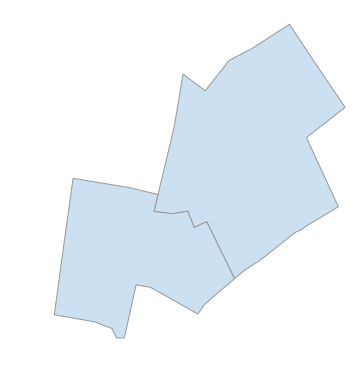

In [27]:
ox.plot_shape(zillow.to_crs(epsg=3857));

### Extract streets within these polygons

- Take the union of the polygons: `unary_union`
- Use `ox.graph_from_polygon()`

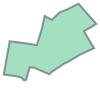

In [28]:
nolibs_fishtown = zillow.geometry.unary_union
nolibs_fishtown

In [29]:
# get the graph
G_nolibs_fishtown = ox.graph_from_polygon(nolibs_fishtown, 
                                          network_type='drive')

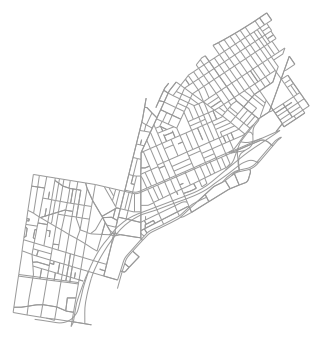

In [30]:
# viola!
ox.plot_graph(ox.project_graph(G_nolibs_fishtown), node_size=0);

We could also use `unary_union.convex_hull`. This will be an encompassing polygon around any set of geometries.

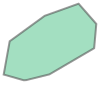

In [31]:
zillow.geometry.unary_union.convex_hull

## Converting from a graph to a GeoDataFrame

Key function: `ox.graph_to_gdfs()`

Can get a GeoDataFrame for both the nodes (points) and edges (lines)

In [32]:
# only get the edges
nolibs_edges = ox.graph_to_gdfs(G_nolibs_fishtown, 
                                edges=True, nodes=False)


In [33]:
# we have lots of data associated with each edge!
nolibs_edges.head()

bridge                                           geometry      highway  key  \
0    NaN  LINESTRING (-75.146372 39.9645781, -75.14655 3...  residential    0   
1    NaN  LINESTRING (-75.146372 39.9645781, -75.146269 ...     tertiary    1   
2    NaN  LINESTRING (-75.1461659 39.965443, -75.1460929...     tertiary    0   
3    NaN  LINESTRING (-75.1461659 39.965443, -75.1463711...  residential    0   
4    NaN  LINESTRING (-75.1472404 39.9578118, -75.147385...        trunk    0   

  lanes   length maxspeed               name  oneway                   osmid  \
0   NaN  117.685      NaN   North 5th Street   False                12109175   
1   NaN   97.779      NaN   North 5th Street    True                49961130   
2   NaN   32.185      NaN   North 5th Street    True                49961130   
3   NaN  117.685      NaN   North 5th Street   False                12109175   
4     5  135.861      NaN  Callowhill Street    True  [424804073, 121643778]   

   ref          u          v  
0  NaN  109729430  109729453  
1  NaN  109729430  109729453  
2  NaN  109729453  109729801  
3  NaN  109729453  109729430  
4  NaN  109729699  109811674

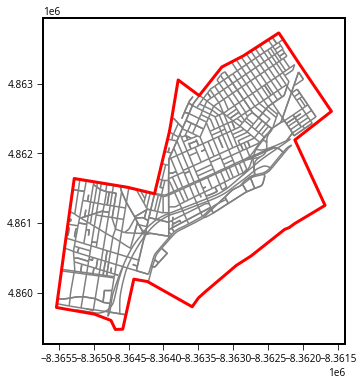

In [34]:
# plot it like any old GeoDataFrame
ax = nolibs_edges.to_crs(epsg=3857).plot(color='gray')

# add the neighborhood boundaries
boundary = gpd.GeoSeries([nolibs_fishtown], crs={'init':'epsg:4326'})
boundary.to_crs(epsg=3857).plot(ax=ax, facecolor='none', edgecolor='red', linewidth=3, zorder=2);

## What can we do with the graph?

- Network-based statistics
- Routing
- Street orientations
- Visualizing crashes

And much more: see the [OSMnx repository of Jupyter notebook examples](https://github.com/gboeing/osmnx-examples/tree/master/notebooks)

## Network statistics

Two functions: 
- `ox.basic_stats()`
- `ox.extended_stats()`

In [35]:
ox.basic_stats(G_nolibs_fishtown)

{'n': 632,
 'm': 1263,
 'k_avg': 3.9968354430379747,
 'intersection_count': 615,
 'streets_per_node_avg': 3.4098101265822787,
 'streets_per_node_counts': {0: 0, 1: 17, 2: 1, 3: 329, 4: 278, 5: 5, 6: 2},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.02689873417721519,
  2: 0.0015822784810126582,
  3: 0.5205696202531646,
  4: 0.439873417721519,
  5: 0.007911392405063292,
  6: 0.0031645569620253164},
 'edge_length_total': 107542.74199999995,
 'edge_length_avg': 85.14864766429133,
 'street_length_total': 88880.72899999996,
 'street_length_avg': 86.37582993197276,
 'street_segments_count': 1029,
 'node_density_km': None,
 'intersection_density_km': None,
 'edge_density_km': None,
 'street_density_km': None,
 'circuity_avg': 1.0160447165826367,
 'self_loop_proportion': 0.0,
 'clean_intersection_count': None,
 'clean_intersection_density_km': None}

## Finding the shortest route

We can use the `networkx` package to do network-based calculations

In [36]:
# two points in Northern Liberties / Fishtown
spring_garden_station = (39.960421, -75.140340)
frankford_hall = (39.969381, -75.134599)

# get the nearest network node to each point
orig_node = ox.get_nearest_node(G_nolibs_fishtown, 
                                spring_garden_station) 
dest_node = ox.get_nearest_node(G_nolibs_fishtown, 
                                frankford_hall) 

In [37]:
import networkx as nx

In [38]:
# get the shortest path --> just a list of node IDs
route = nx.shortest_path(G_nolibs_fishtown, 
                         orig_node, dest_node, 
                         weight='length')
route

[110156961,
 110156976,
 110240102,
 110240110,
 110156990,
 110408354,
 110150984,
 110151026,
 109812663,
 3405862196,
 110274404,
 786190278,
 786189685,
 786189751,
 786190146,
 786189922,
 110227372,
 110549183,
 110207010,
 1479201371,
 2178025740,
 110447532,
 109801799,
 109998370]

Use `ox.plot_graph_route()` to plot a graph and highlight a specific route

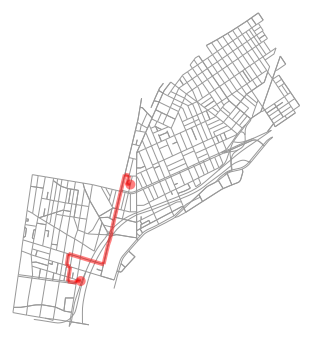

In [39]:
ox.plot_graph_route(G_nolibs_fishtown, route, node_size=0);

## Street Orientations

An amazing visualization of the orientations of city street networks from the author of OSMnx.

[See this blog post on US cities](https://geoffboeing.com/2018/07/comparing-city-street-orientations/)

[And this blog post on world cities](https://geoffboeing.com/2018/07/city-street-orientations-world//)

<center>
    <img src=attachment:Screen%20Shot%202019-03-26%20at%2010.23.13%20PM.png width=700>
</center>
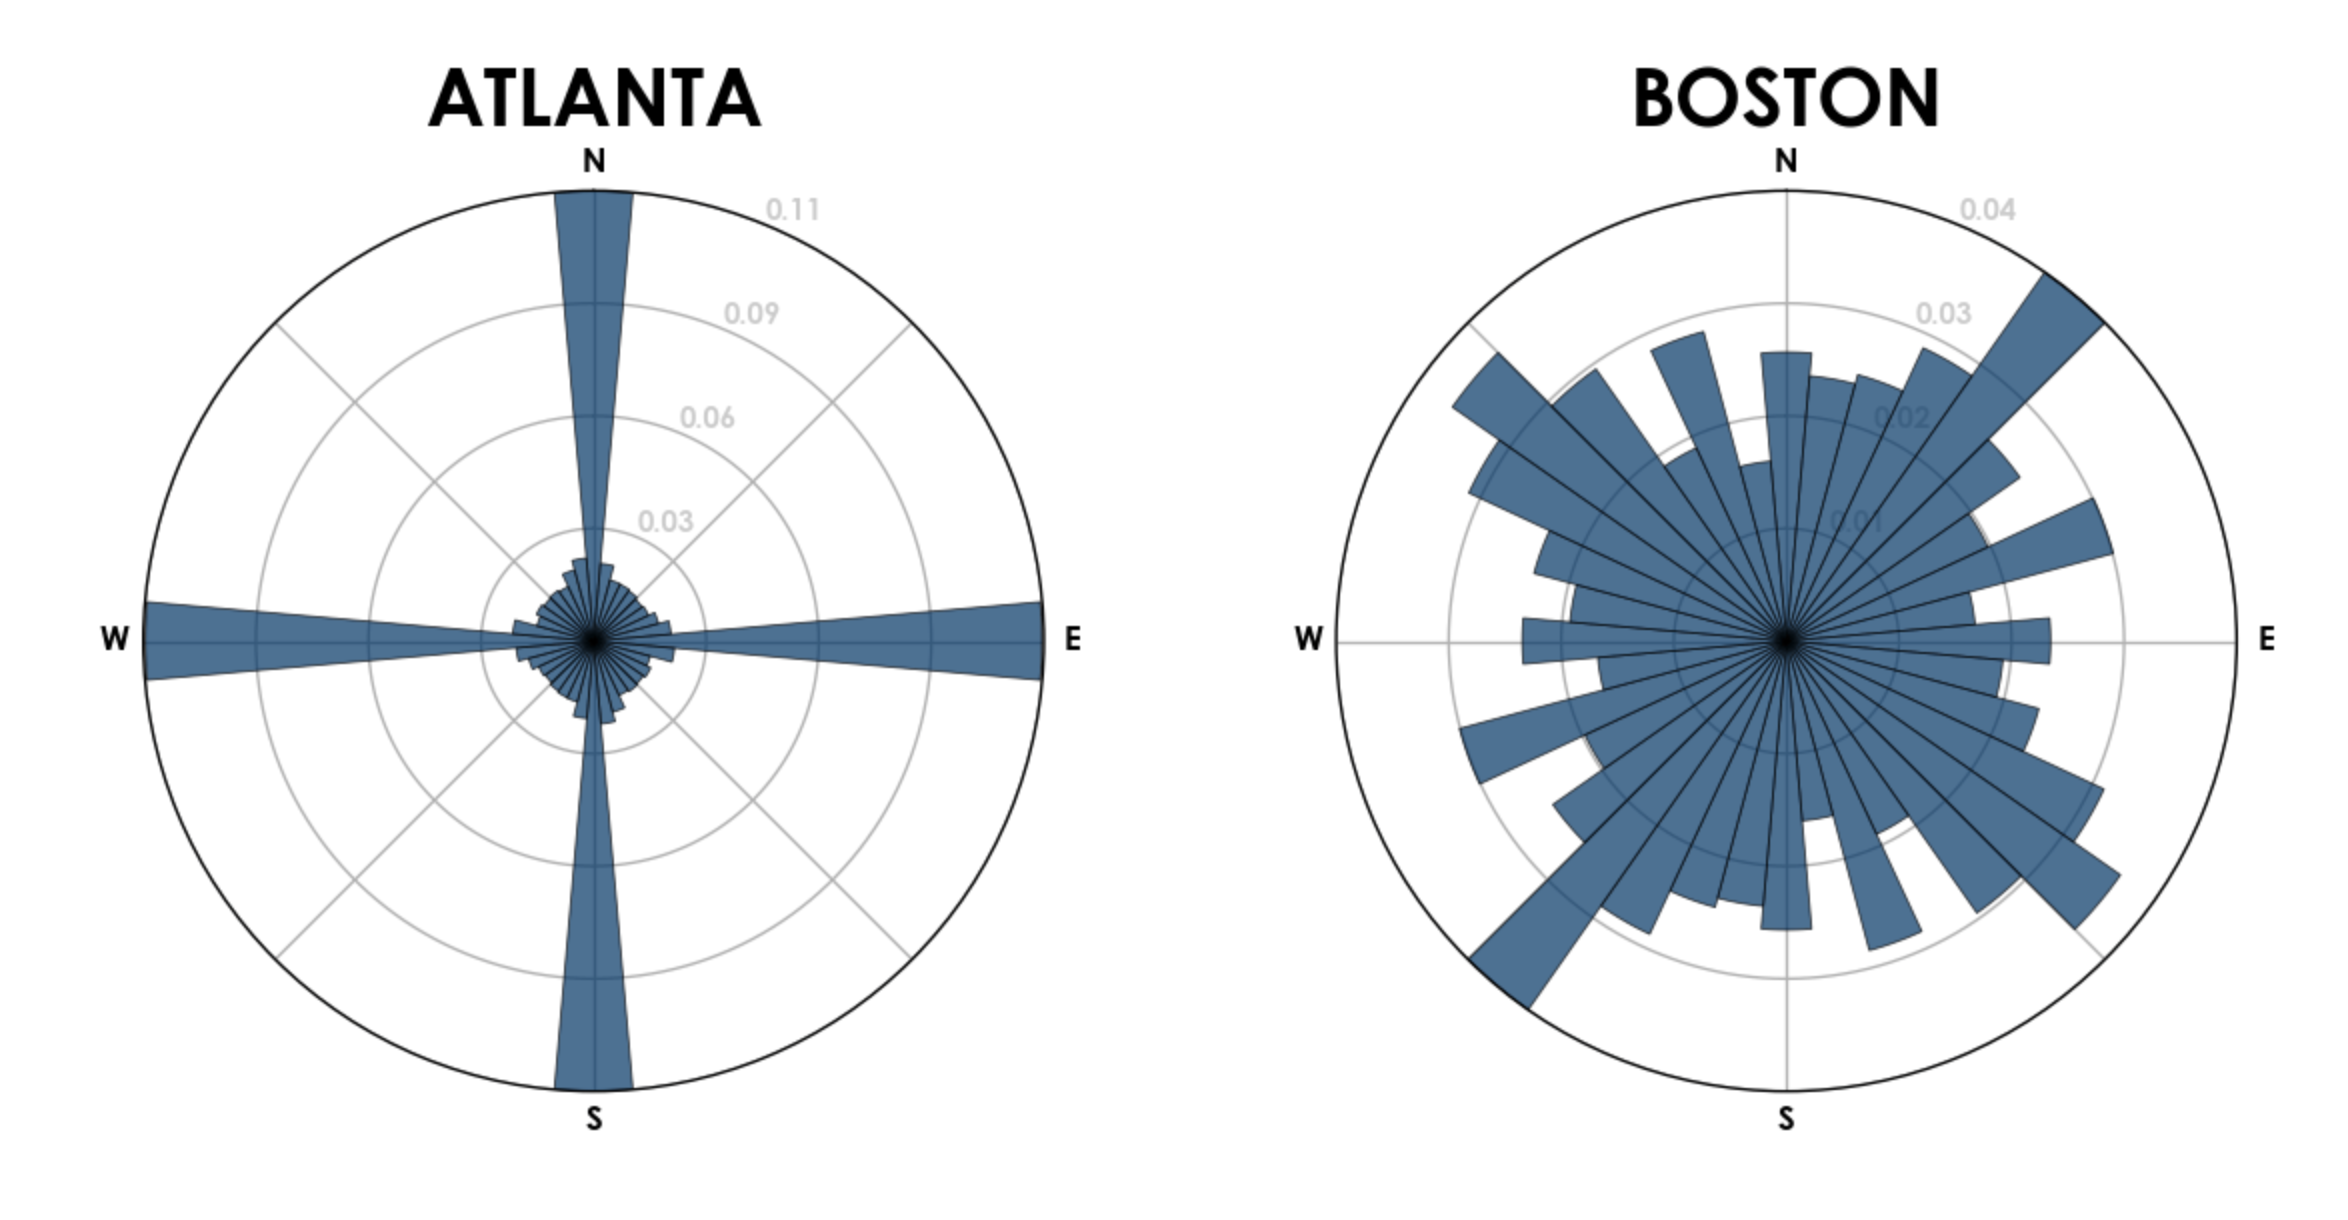

## Two steps: 

1. Add edge bearings to the data attributes of your graph
1. Loop over edges and extract those bearings into a pandas Series

In [40]:
# calculate edge bearings and visualize their frequency
G = ox.add_edge_bearings(G_nolibs_fishtown)

# extract bearings from the edges of the graph
bearings = pd.Series([data['bearing'] for u, v, data in G.edges(keys=False, data=True)])

## Plot a regular old histogram

We can use matplotlib's `hist` function

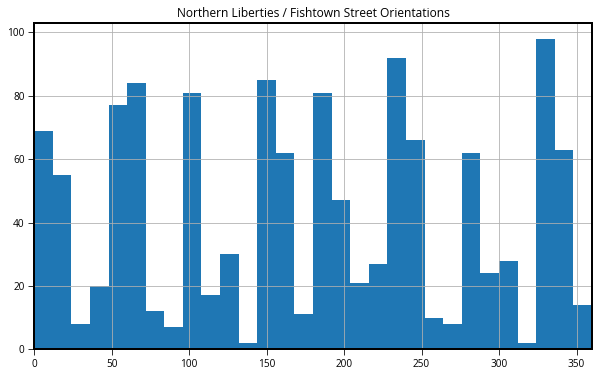

In [41]:
ax = bearings.hist(bins=30)
xlim = ax.set_xlim(0, 360)
ax.set_title('Northern Liberties / Fishtown Street Orientations')
plt.show()

## Can we do better? 

Radial histograms!

In [42]:
def plot_radial_hist(bearings, nbins=30):
    """
    Plot a radial histogram of the input edge bearings.
    """
    # equally spaced theta bins
    theta_bins = np.linspace(0, 360, nbins)
    
    # caculate the histogram
    bin_counts, bin_edges = np.histogram(bearings, bins=theta_bins)
    
    # the centers of the theta bins
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    # the widths of each bins
    bin_widths = np.diff(bin_edges)

    # initializ a polar plot
    fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
    ax.set_theta_zero_location('N')
    ax.set_theta_direction('clockwise')
    
    # convert angles to radians
    bin_centers = np.radians(bin_centers)
    bin_widths = np.radians(bin_widths)
    
    # make a bar plot
    bars = ax.bar(x=bin_centers, height=bin_counts, width=bin_widths)
    
    return fig, ax


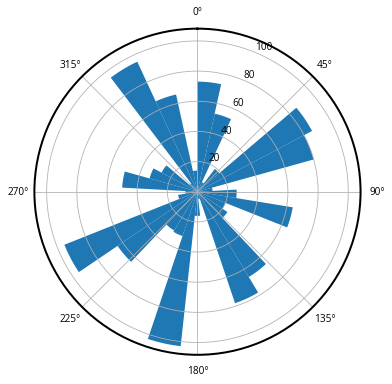

In [43]:
plot_radial_hist(bearings);

## Lab: Visualizing crash data in Philadelphia

### Step 1: choose your network region

There are a few different ways to do this: 
- Choose a Zillow neighborhood, load the shape file, and get its boundary
- Choose an address or lat/lng point and get the network within a given distance
- Use a bounding box (see the tool http://boundingbox.klokantech.com/ for helping pick a bounding box)

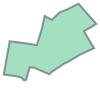

In [44]:
zillow_boundary = zillow.geometry.unary_union
zillow_boundary

### Step 2: get the street network graph

Use the appropriate function from OSMnx, e.g., `ox.graph_from_*`


In [45]:
# get the graph
G_nolibs_fishtown = ox.graph_from_polygon(zillow_boundary, 
                                          network_type='drive')

### Step 3: Convert your network graph edges to a GeoDataFrame

See: `ox.graph_to_gdfs()`

In [46]:
# only get the edges
nolibs_edges = ox.graph_to_gdfs(G_nolibs_fishtown, 
                                edges=True, nodes=False)

In [47]:
nolibs_edges.head()

bridge                                           geometry      highway  key  \
0    NaN  LINESTRING (-75.146372 39.9645781, -75.14655 3...  residential    0   
1    NaN  LINESTRING (-75.146372 39.9645781, -75.146269 ...     tertiary    1   
2    NaN  LINESTRING (-75.1461659 39.965443, -75.1460929...     tertiary    0   
3    NaN  LINESTRING (-75.1461659 39.965443, -75.1463711...  residential    0   
4    NaN  LINESTRING (-75.1472404 39.9578118, -75.147385...        trunk    0   

  lanes   length maxspeed               name  oneway                   osmid  \
0   NaN  117.685      NaN   North 5th Street   False                12109175   
1   NaN   97.779      NaN   North 5th Street    True                49961130   
2   NaN   32.185      NaN   North 5th Street    True                49961130   
3   NaN  117.685      NaN   North 5th Street   False                12109175   
4     5  135.861      NaN  Callowhill Street    True  [424804073, 121643778]   

   ref          u          v  
0  NaN  109729430  109729453  
1  NaN  109729430  109729453  
2  NaN  109729453  109729801  
3  NaN  109729453  109729430  
4  NaN  109729699  109811674

### Step 4: Load PennDOT crash data

Data for 2017 crashes (of all types) is available at the following path:

`./data/penndot_crashes/Philadelphia_CRASH_2017.csv`

Downloaded from: https://crashinfo.penndot.gov/PCIT/welcome.html



In [48]:
crashes = pd.read_csv("./data/penndot_crashes/Philadelphia_CRASH_2017.csv")

In [49]:
crashes.head()

CRN  DISTRICT  COUNTY  MUNICIPALITY POLICE_AGCY  CRASH_YEAR  \
0  2017049066         6      67         67301       67504        2017   
1  2017010655         6      67         67301       67301        2017   
2  2017050090         6      67         67301       67504        2017   
3  2017007838         6      67         67301       67301        2017   
4  2017037375         6      67         67301       67301        2017   

   CRASH_MONTH  DAY_OF_WEEK  TIME_OF_DAY  HOUR_OF_DAY  ...  \
0            5            7         2230           22  ...   
1            1            7         1135           11  ...   
2            5            3         1908           19  ...   
3            1            4          725            7  ...   
4            3            7         1708           17  ...   

   BICYCLE_MAJ_INJ_COUNT  PED_COUNT  PED_DEATH_COUNT  PED_MAJ_INJ_COUNT  \
0                      0          0                0                  0   
1                      0          0                0                  0   
2                      0          0                0                  0   
3                      0          0                0                  0   
4                      0          0                0                  0   

   MAX_SEVERITY_LEVEL COMM_VEH_COUNT  DEC_LAT DEC_LONG  RDWY_SURF_TYPE_CD  \
0                   8              0  39.9536 -75.1986                      
1                   4              0  40.0190 -75.1173                      
2                   0              1  39.9471 -75.1918                      
3                   0              0  39.9386 -75.1421                      
4                   0              0  39.9238 -75.2249                      

               COUNTY_NAME  
0  CRASH_2017_Philadelphia  
1  CRASH_2017_Philadelphia  
2  CRASH_2017_Philadelphia  
3  CRASH_2017_Philadelphia  
4  CRASH_2017_Philadelphia  

[5 rows x 89 columns]

### Step 5: Convert the crash data to a GeoDataFrame

You will need to use the `DEC_LAT` and `DEC_LONG` columns for latitude and longitude.

The full data dictionary for the data is [available here].(http://pennshare.maps.arcgis.com/sharing/rest/content/items/ffe20c6c3c594389b275c6772a281bcd/data)

For help on the Pandas to GeoPandas conversion, see [this documentation](https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html).

In [50]:
from shapely.geometry import Point

In [51]:
crashes['Coordinates'] = list(zip(crashes.DEC_LONG, crashes.DEC_LAT))
crashes['Coordinates'] = crashes['Coordinates'].apply(Point)

crashes = gpd.GeoDataFrame(crashes, geometry='Coordinates', crs={'init':'epsg:4326'})

### Step 6: Trim the crash data

1. Get the boundary of the edges data frame (from Step #3). Accessing the `.geometry.unary_union.convex_hull` property will give you a nice outer boundary region.
1. Trim the crashes using the `within()` function of the crash GeoDataFrame to find which crashes are within the boundary.

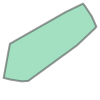

In [52]:
edges_boundary = nolibs_edges.unary_union.convex_hull
edges_boundary

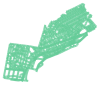

In [53]:
# the union of all of the street edges is not useful in this case!
bad_boundary = nolibs_edges.unary_union
bad_boundary

In [54]:
selection = crashes.within(edges_boundary)
nolibs_crashes = crashes.loc[selection]

In [55]:
selection

0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14       False
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27       False
28       False
29        True
         ...  
11091    False
11092    False
11093    False
11094    False
11095    False
11096    False
11097    False
11098    False
11099    False
11100     True
11101    False
11102    False
11103    False
11104    False
11105    False
11106    False
11107    False
11108    False
11109    False
11110    False
11111    False
11112    False
11113    False
11114    False
11115    False
11116    False
11117    False
11118    False
11119    False
11120    False
Length: 11121, dtype: bool

In [56]:
print("found %d crashes within Northern Liberties / Fishtown..." % (len(nolibs_crashes)))

found 297 crashes within Northern Liberties / Fishtown...


### Step 7: Find the nearest edge for each crash

See: `ox.get_nearest_edges()`. It takes three arguments:

- the network graph
- the latitude of your crash data (the `y` attribute of the `geometry` column)
- the longitude of your crash data (the `x` attribute of the `geometry` column)

You will get a list of `(u,v)` where each `u` and `v` are a node ID.

In [57]:
nearest = ox.get_nearest_edges(G_nolibs_fishtown, 
                               nolibs_crashes.geometry.y, 
                               nolibs_crashes.geometry.x)

In [59]:
nearest

array([[ 110408246, 3405862197],
       [ 109729709,  109811681],
       [ 110028737,  110219407],
       [ 109811705,  109811697],
       [ 110239793,  110314761],
       [ 109738876,  109738982],
       [1479201371, 1479201402],
       [ 109767680,  109896601],
       [ 109921856,  109921846],
       [ 110157004,  110248935],
       [ 110021938,  110207056],
       [ 109767680,  109896601],
       [ 109742534,  109738876],
       [ 110297446,  110297457],
       [ 109767680,  109896601],
       [ 109981828,  110297540],
       [ 109738982,  109767943],
       [ 109753477,  109742534],
       [ 109767680,  109896601],
       [ 109729805,  109729811],
       [ 109738982,  109767943],
       [ 634779464,  110399916],
       [ 109767680,  109896601],
       [2787032931,  110250592],
       [ 109767680,  109896601],
       [ 110176615, 1479206117],
       [ 109921746,  110509965],
       [ 634779287,  110287092],
       [ 110447532, 2178025740],
       [ 109981828,  110297540],
       [ 1

### Step 8: Calculate the total number of crashes per street

1. Make a DataFrame from your data from Step 7 with two columns, `u` and `v`
1. Group by `u` and `v` and calculate the size
1. Reset the index (and name your `size()` column)

In [60]:
df = pd.DataFrame(nearest, columns=['u', 'v'])
counts = df.groupby(['u','v']).size().reset_index(name='crash_count')

In [61]:
counts

u           v  crash_count
0     109729709   109729731            2
1     109729709   109811681            3
2     109729731   109729739            3
3     109729805   109729811            1
4     109738876   109738982            6
5     109738982   109739090            1
6     109738982   109767943            5
7     109739547   110225794            2
8     109739559   110225812            7
9     109742534   109738876           27
10    109742690   109742534            1
11    109753452   110286924            2
12    109753477   109742534            6
13    109753494   110297540            1
14    109767680   109896601           37
15    109796175   109921057            1
16    109811705   109811697            3
17    109811789   109811783            1
18    109877009   634779464            2
19    109896273   109767680            6
20    109896601  5299748445            1
21    109900871   110314709            1
22    109902677   110176782            1
23    109902720   109902734            1
24    109912716   109921065            1
25    109921065   110447532            1
26    109921746   110509965            2
27    109921856   109921846            1
28    109981736   110218775            1
29    109981828   110297540           13
..          ...         ...          ...
91    634779464   110399916            1
92    775426146   109729699            3
93    786189680   786190278            1
94   1479201345  2178025740            2
95   1479201352  1479201396            3
96   1479201354   109811801            1
97   1479201354  1479201432            1
98   1479201367  1479201364            4
99   1479201368  1479201362            1
100  1479201370  1479206120            2
101  1479201371  1479201402            6
102  1479201380  1479201370            1
103  1479201396  1479201374            3
104  1479201401  1479201345            1
105  1479201421  1479201371            2
106  1479201432  1479201368            2
107  1479206105  1479206109            3
108  1479206106  1479201401            1
109  1479206107  1479206123            1
110  1479206122  1479206107            1
111  1479206124  1479206136            1
112  1479206134   110014848            3
113  1479206142  1479206144            2
114  1827059947   634779313            5
115  1945600318  1479201351            1
116  2713479907   109990240            1
117  2787032931   110250592            1
118  3405862197   110156976            2
119  5299747957  5299747958            4
120  5299748505   109904749            1

[121 rows x 3 columns]

### Step 9: Merge your edges GeoDataFrame and crash count DataFrame

You can use pandas to merge them on the `u` and `v` columns. This will associate the total crash count with each edge in the street network. 

**Tips:** 
   - Use a `left` merge where the first argument of the merge is the edges GeoDataFrame. This ensures no edges are removed during the merge.
   - Use the `fillna(0)` function to fill in missing crash count values with zero.

In [62]:
edges_with_crashes = pd.merge(nolibs_edges, counts, on=['u', 'v'], how='left').fillna(0)

### Step 10: Get the top 10 streets with crashes and plot the streets

You can use GeoPandas to make the plot, coloring the streets by your column of crash counts. 

**Tip:** if the crashes are concentrated are concentrated on a few specific streets, try setting the `vmax` parameter to a relatively low number to limit the dynamic range of the color map (it sets the upper bound of the color map).

In [63]:
edges_with_crashes.sort_values('crash_count', ascending=False).iloc[:10]

bridge                                           geometry  \
60    [yes, viaduct]  LINESTRING (-75.14000590000001 39.9610633, -75...   
43    [yes, viaduct]  LINESTRING (-75.1248822 39.9707293, -75.126411...   
300                0  LINESTRING (-75.11693099999999 39.97532, -75.1...   
42                 0  LINESTRING (-75.1450705 39.9575352, -75.145603...   
1071               0  LINESTRING (-75.1296116 39.9686555, -75.129189...   
34               yes  LINESTRING (-75.1381346 39.9646303, -75.138580...   
1141               0  LINESTRING (-75.13625469999999 39.9688404, -75...   
49           viaduct  LINESTRING (-75.1187377 39.9742899, -75.119439...   
175              yes  LINESTRING (-75.1407198 39.9570603, -75.140718...   
814                0  LINESTRING (-75.118611 39.978879, -75.1188061 ...   

            highway  key lanes    length maxspeed                  name  \
60         motorway    0     4  1580.789   55 mph   Delaware Expressway   
43         motorway    0     4  1339.730   55 mph   Delaware Expressway   
300     residential    0     0   141.566        0          Emery Street   
42            trunk    0     5    55.188        0     Callowhill Street   
1071    residential    0     0    93.629        0  East Columbia Avenue   
34    motorway_link    0     2   368.908        0                     0   
1141      secondary    0     0    43.876        0    West Girard Avenue   
49         motorway    0     3   657.012   55 mph   Delaware Expressway   
175        motorway    0     3   451.726   55 mph   Delaware Expressway   
814         primary    0     5   295.859        0       Aramingo Avenue   

      oneway                                              osmid   ref  \
60      True  [63571968, 63574816, 63572067, 63574883, 63574...  I 95   
43      True  [63574914, 63574925, 43065294, 63574926, 63574...  I 95   
300    False                                           12173901     0   
42      True                                          121643778     0   
1071    True                                          205683983     0   
34      True           [63572032, 63572073, 28745315, 63571964]     0   
1141    True                                          511003864     0   
49      True                                          122095913  I 95   
175     True         [627641200, 63077456, 548599796, 63077464]  I 95   
814    False                  [424809408, 423966836, 424809405]     0   

               u           v  crash_count  
60     109767680   109896601         37.0  
43     109742534   109738876         27.0  
300    109981828   110297540         13.0  
42     109739559   110225812          7.0  
1071   360997842   110369940          6.0  
34     109738876   109738982          6.0  
1141  1479201371  1479201402          6.0  
49     109753477   109742534          6.0  
175    109896273   109767680          6.0  
814    110250592   110297467          5.0

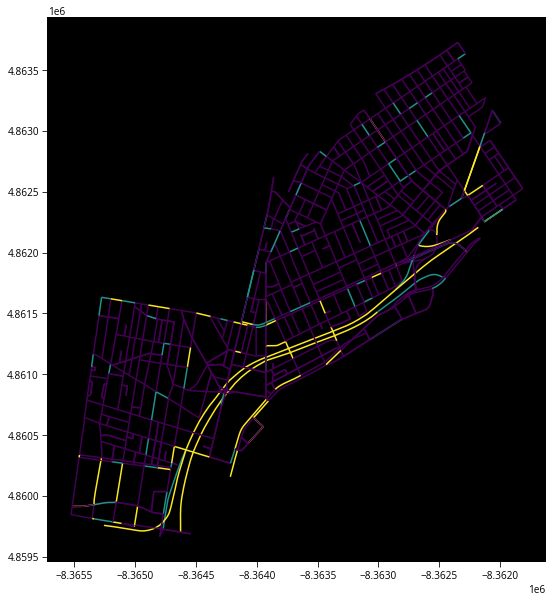

In [66]:
df = edges_with_crashes.to_crs(epsg=3857)
ax = df.plot(column='crash_count', cmap='viridis', vmax=2)


ax.set_facecolor('black')
ax.figure.set_size_inches((10,10))

## Extra exercise: plot a radial histogram of your favorite region

Take a look at the city-wide results from https://geoffboeing.com/2018/07/comparing-city-street-orientations/

### Many more possibilities...

A lot of interesting exploration avenues: the crash data has info on speed, conditions, type of crash, etc, and the data goes back to 1998. 

Data is from https://crashinfo.penndot.gov/PCIT/welcome.html. See the link for "Public Datasets".

**Cool idea / exercise for home:** make a GIF of the crashes in Philadelphia for each year since 1998.

## Part 2:  Pandana

"Pandas Network Analysis - dataframes of network queries, quickly"

A complementary set of OSM-related features: 
- Downloading OSM-based networks
- Extracting amenity data (so-called "Points of Interest")
- Calculating network-constrained distances

- [GitHub](https://github.com/UDST/pandana)
- [Jupyter Notebook Examples](https://github.com/UDST/pandana/tree/master/examples)
- [Documentation](http://udst.github.io/pandana/)

In [67]:
import pandana as pnda
from pandana.loaders import osm

## Step 1: Get amenity data

Key function: `osm.node_query()`

This will extract amenities within a given bounding box.

In [68]:
osm.node_query?

Get the bounding box for Northern Liberties / Fishtown:

In [69]:
boundary = nolibs_fishtown.bounds
boundary

(-75.14887639299997, 39.95549269800006, -75.11346406399997, 39.98475670300007)

In [70]:
[lng_min, lat_min, lng_max, lat_max] = boundary

In [71]:
# query OSM
poi_df = osm.node_query(lat_min, lng_min, lat_max, lng_max)

# remove missing data
poi_df = poi_df.dropna(subset=['amenity'])

In [72]:
poi_df.head()

access addr:city addr:country addr:full addr:housename  \
id                                                                 
357274893    NaN       NaN          NaN       NaN            NaN   
357280489    NaN       NaN          NaN       NaN            NaN   
357283515    NaN       NaN          NaN       NaN            NaN   
357288962    NaN       NaN          NaN       NaN            NaN   
357292065    NaN       NaN          NaN       NaN            NaN   

          addr:housenumber addr:place addr:postcode addr:state addr:street  \
id                                                                           
357274893              NaN        NaN           NaN        NaN         NaN   
357280489              NaN        NaN           NaN        NaN         NaN   
357283515              NaN        NaN           NaN        NaN         NaN   
357288962              NaN        NaN           NaN        NaN         NaN   
357292065              NaN        NaN           NaN        NaN         NaN   

           ... tower:type traffic_signals traffic_signals:direction tram  \
id         ...                                                             
357274893  ...        NaN             NaN                       NaN  NaN   
357280489  ...        NaN             NaN                       NaN  NaN   
357283515  ...        NaN             NaN                       NaN  NaN   
357288962  ...        NaN             NaN                       NaN  NaN   
357292065  ...        NaN             NaN                       NaN  NaN   

          unisex website wheelchair wifi wikidata wikipedia  
id                                                           
357274893    NaN     NaN        NaN  NaN      NaN       NaN  
357280489    NaN     NaN        NaN  NaN      NaN       NaN  
357283515    NaN     NaN        NaN  NaN      NaN       NaN  
357288962    NaN     NaN        NaN  NaN      NaN       NaN  
357292065    NaN     NaN        NaN  NaN      NaN       NaN  

[5 rows x 121 columns]

In [73]:
poi_df[['lat', 'lon', 'amenity']].head(10)

lat        lon           amenity
id                                               
357274893  39.972335 -75.130176            school
357280489  39.969835 -75.126565            school
357283515  39.976224 -75.116842            school
357288962  39.979279 -75.127121            school
357292065  39.984557 -75.134065            school
357297150  39.983168 -75.141566            school
357297875  39.982335 -75.133510            school
357303425  39.960668 -75.147121            school
357303707  39.972851 -75.126838            school
357307010  39.963827 -75.144182  place_of_worship

## Explore the amenities in this region

For the full list of amenities, see the [OSM Wikipedia](https://wiki.openstreetmap.org/wiki/Key:amenity)

In [74]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

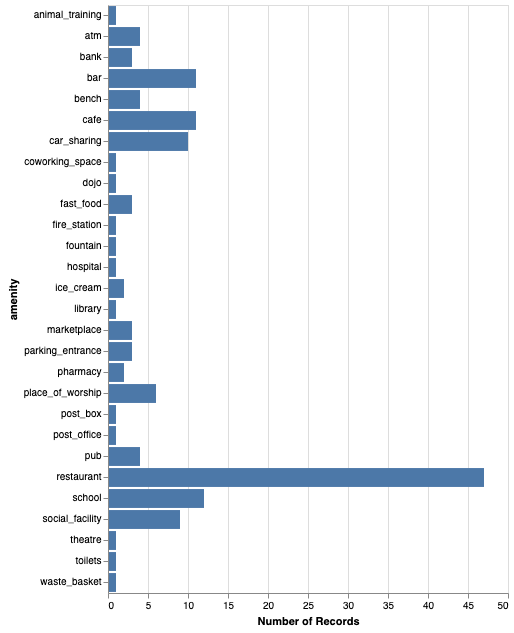

In [75]:
(alt.Chart(poi_df)
.mark_bar()
.encode(y='amenity', 
        x='count()', 
        tooltip=['amenity', 'count()']))

## Step 2: Create a Pandana network

- Key function: `pdna_network_from_bbox()` 
- It takes a bounding box and returns the OSM network within that region. 
- Multiple network types: 'walk' and 'drive'

In [76]:
net = osm.pdna_network_from_bbox(lat_min, lng_min, lat_max, lng_max, 
                                 network_type='walk')

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](39.95549270,-75.14887639,39.98475670,-75.11346406);>;);out;'}"
Downloaded 816.4KB from www.overpass-api.de in 0.84 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 0.94 seconds
Returning OSM data with 4,465 nodes and 1,218 ways...
Edge node pairs completed. Took 3.27 seconds
Returning processed graph with 1,958 nodes and 3,061 edges...
Completed OSM data download and Pandana node and edge table creation in 4.45 seconds


/Users/nhand/anaconda3/envs/py37/lib/python3.6/site-packages/pandana/network.py:82: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  nodes_df.astype('double').as_matrix(),
/Users/nhand/anaconda3/envs/py37/lib/python3.6/site-packages/pandana/network.py:83: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  edges.as_matrix(),
/Users/nhand/anaconda3/envs/py37/lib/python3.6/site-packages/pandana/network.py:85: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  .astype('double')
/Users/nhand/anaconda3/envs/py37/lib/python3.6/site-packages/pandana/network.py:91: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.kdtree = KDTree(nodes_df.as_matrix())


### Step 3: Tell the network the location of amenities

Key function: `network.set_pois()`

In [77]:
# sensible defaults
max_distance = 2000 # in meters
num_pois = 10 # only need the 10 nearest POI to each point in the network

amenities = ['restaurant', 'bar', 'school', 'car_sharing']
for amenity in amenities:
    
    # get the subset of amenities for this type
    pois_subset = poi_df[poi_df['amenity']==amenity]
    
    # set the POI, using the longitude and latitude of POI
    net.set_pois(amenity, max_distance, num_pois, 
                 pois_subset['lon'], pois_subset['lat'])

/Users/nhand/anaconda3/envs/py37/lib/python3.6/site-packages/pandana/network.py:371: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indexes = self.kdtree.query(xys.as_matrix())
/Users/nhand/anaconda3/envs/py37/lib/python3.6/site-packages/pandana/network.py:371: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indexes = self.kdtree.query(xys.as_matrix())
/Users/nhand/anaconda3/envs/py37/lib/python3.6/site-packages/pandana/network.py:371: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indexes = self.kdtree.query(xys.as_matrix())
/Users/nhand/anaconda3/envs/py37/lib/python3.6/site-packages/pandana/network.py:371: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indexes = self.kdtree.query(xys.as_matrix())


In [78]:
# keyword arguments to pass for the matplotlib figure
bbox_aspect_ratio = (lat_max - lat_min) / (lng_max - lng_min)
fig_kwargs = {'facecolor':'w', 
              'figsize':(10, 10 * bbox_aspect_ratio)}

# keyword arguments to pass for scatter plots
plot_kwargs = {'s':20, 
               'alpha':0.9, 
               'cmap':'viridis_r', 
               'edgecolor':'none'}

### Step 4: plot the walking distance to the nearest POI

For every point on the network, find the nth nearest POI, calculate the distance, and color that point according to the distance.

1. Use `network.nearest_poi()` to get distances from nodes to nearest POIs
1. Merge coordinates of network nodes with distances to nearest POIs
1. Plot the node coordinates, colored by distance to nth nearest POI

### 1. Use `network.nearest_poi()` to get distances from nodes to nearest POIs

In [79]:
amenity = 'bar'
access = net.nearest_pois(distance=1000, category=amenity, 
                          num_pois=num_pois)

In [80]:
access.head(n=20)

1            2            3            4            5   \
id                                                                           
103353219  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
103357134  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
103357139  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
103407531  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
103407534  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
103417453  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
103426172  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
103426218  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
103439886  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
103449512  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
103455424  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
103455428  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
109729330   862.343994  1000.000000  1000.000000  1000.000000  1000.000000   
109729372   734.604980  1000.000000  1000.000000  1000.000000  1000.000000   
109729430   513.142029   608.004028   619.443970   636.344971   636.344971   
109729453   420.438995   600.973022   619.364990   648.051025   705.794006   
109729661   792.289001  1000.000000  1000.000000  1000.000000  1000.000000   
109729673   725.815002  1000.000000  1000.000000  1000.000000  1000.000000   
109729699   615.765991   917.443970   917.443970  1000.000000  1000.000000   
109729709   528.090027   829.768005   829.768005   987.039978  1000.000000   

                    6            7            8            9       10  
id                                                                     
103353219  1000.000000  1000.000000  1000.000000  1000.000000  1000.0  
103357134  1000.000000  1000.000000  1000.000000  1000.000000  1000.0  
103357139  1000.000000  1000.000000  1000.000000  1000.000000  1000.0  
103407531  1000.000000  1000.000000  1000.000000  1000.000000  1000.0  
103407534  1000.000000  1000.000000  1000.000000  1000.000000  1000.0  
103417453  1000.000000  1000.000000  1000.000000  1000.000000  1000.0  
103426172  1000.000000  1000.000000  1000.000000  1000.000000  1000.0  
103426218  1000.000000  1000.000000  1000.000000  1000.000000  1000.0  
103439886  1000.000000  1000.000000  1000.000000  1000.000000  1000.0  
103449512  1000.000000  1000.000000  1000.000000  1000.000000  1000.0  
103455424  1000.000000  1000.000000  1000.000000  1000.000000  1000.0  
103455428  1000.000000  1000.000000  1000.000000  1000.000000  1000.0  
109729330  1000.000000  1000.000000  1000.000000  1000.000000  1000.0  
109729372  1000.000000  1000.000000  1000.000000  1000.000000  1000.0  
109729430   665.971008   717.155029   745.841003   941.802002  1000.0  
109729453   717.234009   734.135010   734.135010   869.257019  1000.0  
109729661  1000.000000  1000.000000  1000.000000  1000.000000  1000.0  
109729673  1000.000000  1000.000000  1000.000000  1000.000000  1000.0  
109729699  1000.000000  1000.000000  1000.000000  1000.000000  1000.0  
109729709  1000.000000  1000.000000  1000.000000  1000.000000  1000.0

### 2. Merge coordinates of network nodes with distances to nearest POIs

In [81]:
def to_geopandas(df, xcol='x', ycol='y'):
    """
    Utility function to convert from DataFrame to GeoDataFrame
    """
    df['geometry'] = df.apply(lambda row: Point(row[xcol], row[ycol]), axis=1)
    return gpd.GeoDataFrame(df, geometry='geometry', crs={'init':'epsg:4326'})

In [82]:
nodes = pd.merge(net.nodes_df, access, left_index=True, right_index=True)    
nodes = to_geopandas(nodes)

In [83]:
nodes.head()

x          y       1       2       3       4       5  \
id                                                                        
103353219 -75.115434  39.957472  1000.0  1000.0  1000.0  1000.0  1000.0   
103357134 -75.114734  39.954193  1000.0  1000.0  1000.0  1000.0  1000.0   
103357139 -75.113843  39.957221  1000.0  1000.0  1000.0  1000.0  1000.0   
103407531 -75.120641  39.955889  1000.0  1000.0  1000.0  1000.0  1000.0   
103407534 -75.119286  39.955627  1000.0  1000.0  1000.0  1000.0  1000.0   

                6       7       8       9      10  \
id                                                  
103353219  1000.0  1000.0  1000.0  1000.0  1000.0   
103357134  1000.0  1000.0  1000.0  1000.0  1000.0   
103357139  1000.0  1000.0  1000.0  1000.0  1000.0   
103407531  1000.0  1000.0  1000.0  1000.0  1000.0   
103407534  1000.0  1000.0  1000.0  1000.0  1000.0   

                                       geometry  
id                                               
103353219        POINT (-75.1154344 39.9574724)  
103357134        POINT (-75.1147338 39.9541931)  
103357139          POINT (-75.113843 39.957221)  
103407531        POINT (-75.1206414 39.9558895)  
103407534  POINT (-75.11928589999999 39.955627)

### And now plot it!

Let's define a function to do this for us, since we'll repeat this plot multiple times

In [84]:
def plot_walking_distance(net, amenity, distance=1000, n=1):

    # subset of POI
    poi_subset = poi_df[poi_df['amenity']==amenity]
    
    # get the distances to nearest num_pois POI
    access = net.nearest_pois(distance=1000, category=amenity, num_pois=num_pois)

    # merge node positions and distances to nearest PO
    nodes = pd.merge(net.nodes_df, access, left_index=True, right_index=True)    
    nodes = to_geopandas(nodes)
    
    # plot the distance to the nth nearest amenity
    ax = nodes.plot(column=nodes[n], legend=True, **plot_kwargs)
    
    # add the amenities as stars
    for i, row in poi_subset.iterrows():
        ax.scatter(row['lon'], row['lat'], color='red', s=100, marker='*')
    
    # format
    ax.set_facecolor('black')
    ax.figure.set_size_inches(fig_kwargs['figsize'])
    
    # set extent
    [xmin, ymin, xmax, ymax] = nodes.geometry.total_bounds
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    return ax

### Evaluating amenity choice

The difference between maps to the nearest amenity and for example, the 5th nearest amenity tells us about the options consumers have

## Example: bars

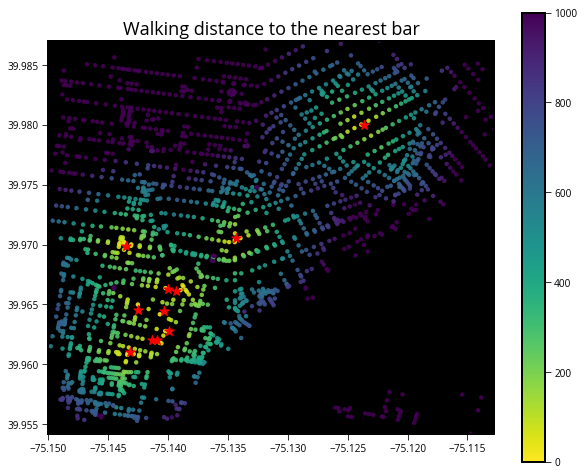

In [85]:
ax = plot_walking_distance(net, "bar", n=1)
ax.set_title("Walking distance to the nearest bar", fontsize=18);

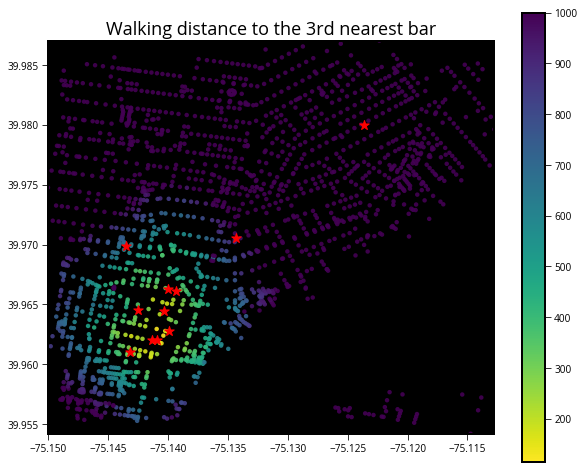

In [86]:
ax = plot_walking_distance(net, "bar", n=3)
ax.set_title("Walking distance to the 3rd nearest bar", fontsize=18);

## Example: schools

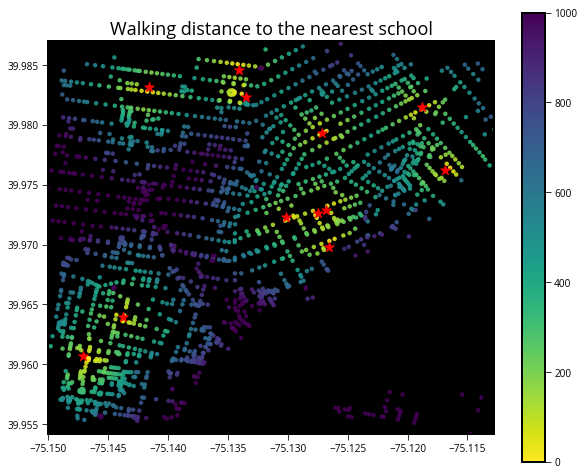

In [87]:
ax = plot_walking_distance(net, "school", n=1)
ax.set_title("Walking distance to the nearest school", fontsize=18);

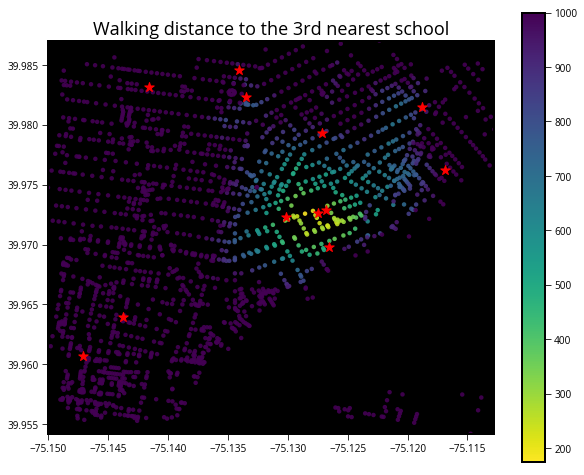

In [88]:
ax = plot_walking_distance(net, "school", n=3)
ax.set_title("Walking distance to the 3rd nearest school", fontsize=18);

## Example: restaurants

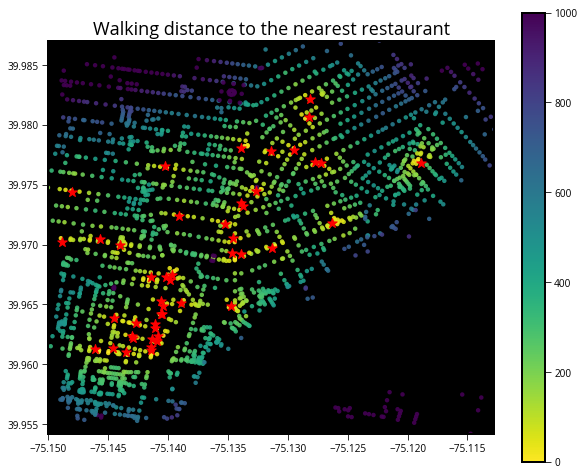

In [89]:
ax = plot_walking_distance(net, "restaurant", n=1)
ax.set_title("Walking distance to the nearest restaurant", fontsize=18);

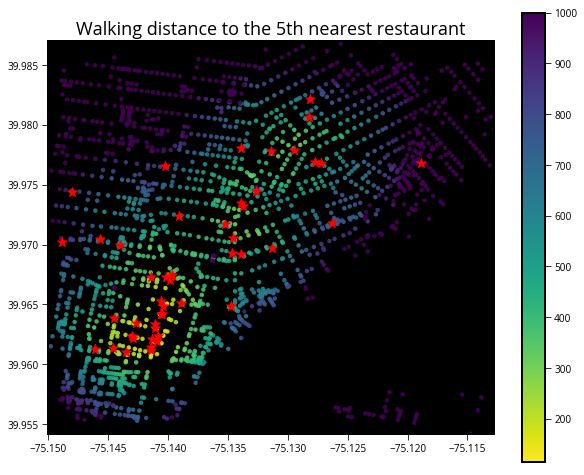

In [90]:
ax = plot_walking_distance(net, "restaurant", n=5)
ax.set_title("Walking distance to the 5th nearest restaurant", fontsize=18);

## Example: car sharing

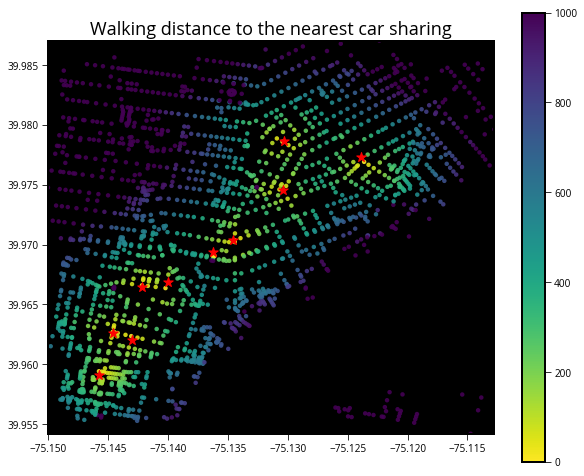

In [91]:
ax = plot_walking_distance(net, "car_sharing", n=1)
ax.set_title("Walking distance to the nearest car sharing", fontsize=18);

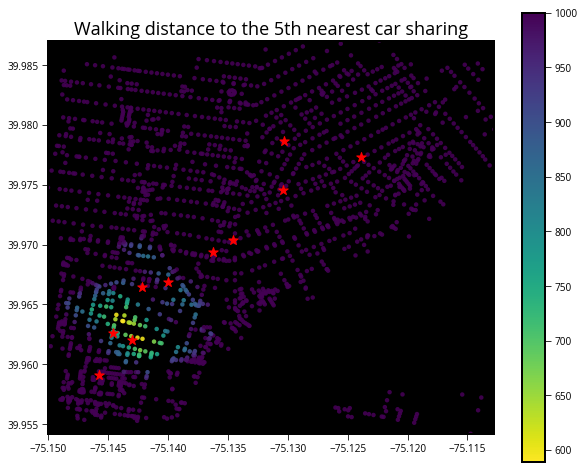

In [92]:
ax = plot_walking_distance(net, "car_sharing", n=5)
ax.set_title("Walking distance to the 5th nearest car sharing", fontsize=18);

## Exercise: explore amenities in the neighborhood of your choice

Many, many more amenities are logged throughout the city. Pick your favorite neighborhood and explore. 

See [this page](https://wiki.openstreetmap.org/wiki/Key:amenity) for the full list of amenities.